C:\Users\Hp OMEN\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RGB:  610
[[[ 342  194  305]
  [ 367  233  329]
  [ 276  154  319]
  ...
  [ 768  381  494]
  [ 824  498  538]
  [ 809  477  482]]

 [[ 365  271  218]
  [ 288  184  268]
  [ 167   95  300]
  ...
  [ 821  465  455]
  [ 859  463  509]
  [ 803  468  418]]

 [[ 375  233  304]
  [ 250  139  347]
  [ 153  133  233]
  ...
  [ 879  599  588]
  [ 843  551  584]
  [ 809  562  538]]

 ...

 [[ 938  800  610]
  [1069  874  882]
  [ 971  772  950]
  ...
  [ 521  286  317]
  [ 535  336  284]
  [ 572  333  397]]

 [[ 892  665  582]
  [1091  772  798]
  [1101  927  861]
  ...
  [ 606  393  314]
  [ 673  363  402]
  [ 586  335  370]]

 [[ 946  677  719]
  [1004  800  709]
  [1184  981  926]
  ...
  [ 648  386  355]
  [ 648  393  454]
  [ 582  389  319]]]
GT:  610
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]]


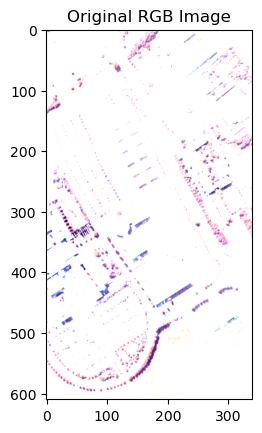

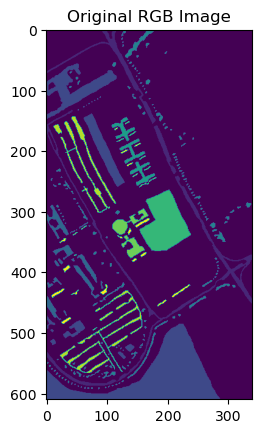

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Load data from MATLAB file
mat_data = scipy.io.loadmat('PaviaU.mat')
groundTruthData = scipy.io.loadmat('PaviaU_gt.mat')

groundTruth = groundTruthData['paviaU_gt']

# Extract the hyperspectral data
hyperspectral_data = mat_data['paviaU']

# Choose bands for RGB channels
red_band = hyperspectral_data[:, :, 29]
green_band = hyperspectral_data[:, :, 19]
blue_band = hyperspectral_data[:, :, 9]

# Combine bands to create an RGB image
rgb_image = np.stack((red_band, green_band, blue_band), axis=-1)

print("RGB: ", len(rgb_image))
print(rgb_image)

print("GT: ", len(groundTruth))
print(groundTruth)

# Display the RGB image
plt.imshow(rgb_image)
plt.title('Original RGB Image')
plt.show()

# Display the RGB image
plt.imshow(groundTruth)
plt.title('Original RGB Image')
plt.show()

In [2]:
import numpy as np

def extract_tiles(image, gt, tile_size=(64, 64)):
    tiles = []
    labels = []
    image_height, image_width, _ = image.shape

    # Calculate the number of tiles in each dimension
    num_tiles_height = image_height // tile_size[0]
    num_tiles_width = image_width // tile_size[1]

    for i in range(num_tiles_height):
        for j in range(num_tiles_width):
            # Extract a tile from the image
            start_h = i * tile_size[0]
            end_h = start_h + tile_size[0]
            start_w = j * tile_size[1]
            end_w = start_w + tile_size[1]

            tile = image[start_h:end_h, start_w:end_w, :]
            label = gt[start_h:end_h, start_w:end_w]

            # Append the tile to the list
            tiles.append(tile)
            labels.append(label)

    return tiles, labels

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

height, width, channels = rgb_image.shape
tile_size=(64, 64)
# Assuming 'data' is your hyperspectral data
tiles, labels = extract_tiles(rgb_image, groundTruth, tile_size)  # Implement extract_tiles function

tiles = np.array(tiles)
labels = np.array(labels)

tiles = tiles.reshape(-1, tile_size[0], tile_size[1], channels)
# # Ensure ground truth has the same number of samples as tiles
# ground_truth_flat = groundTruth.flatten()

# # Use the minimum of the lengths to ensure consistency
# min_length = min(len(tiles), len(ground_truth_flat))

# Split into training and testing sets
#train_tiles, test_tiles, train_ground_truth, test_ground_truth = train_test_split(
#    tiles[:min_length], ground_truth_flat[:min_length], test_size=0.2, random_state=42
#)

train_tiles, test_tiles, trainGT, testGT = train_test_split(tiles, labels, test_size=0.2, random_state=42)

# # Convert ground truth to categorical
# train_ground_truth_categorical = to_categorical(train_ground_truth)
# test_ground_truth_categorical = to_categorical(test_ground_truth)

print("Train set - Tiles:", train_tiles.shape, "Labels:", trainGT.shape)
print("Test set - Tiles:", test_tiles.shape, "Labels:", testGT.shape)

Train set - Tiles: (36, 64, 64, 3) Labels: (36, 64, 64)
Test set - Tiles: (9, 64, 64, 3) Labels: (9, 64, 64)


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Generate augmented samples
num_augmented_samples = 16
augmented_data = []
augmented_labels = []
# Create an ImageDataGenerator instance with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
for j in range(num_augmented_samples):
    augmented_images = datagen.flow(tiles, batch_size=1)
    augmented_masks = datagen.flow(labels[..., None], batch_size=1)  # Add a channel dimension to label

    # Extract augmented samples
    for j in range(num_augmented_samples):
        augmented_data.append(augmented_images.next()[0])
        augmented_labels.append(augmented_masks.next()[0][:, :, 0])  # Remove the added channel dimension

# Convert lists to NumPy arrays
augmented_data = np.array(augmented_data)
augmented_labels = np.array(augmented_labels)

# Check the shapes of the augmented data
print("Augmented Data shape:", augmented_data.shape)
print("Augmented Labels shape:", augmented_labels.shape)

# Combine original and augmented data for training
combined_train_tiles = np.concatenate((train_tiles, augmented_data), axis=0)
combined_train_labels = np.concatenate((trainGT, augmented_labels), axis=0)


Augmented Data shape: (256, 64, 64, 3)
Augmented Labels shape: (256, 64, 64)


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def create_segmentation_model():
    input_img = Input(shape=(64, 64, 3))
    
    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    
    # Bottom layer
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    
    # Decoder
    up1 = UpSampling2D((2, 2))(conv3)
    concat1 = concatenate([conv2, up1], axis=-1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    
    up2 = UpSampling2D((2, 2))(conv4)
    concat2 = concatenate([conv1, up2], axis=-1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat2)
    
    output = Conv2D(10, (1, 1), activation='softmax')(conv5)  # Adjusted for 9 classes with softmax activation
    
    model = Model(inputs=input_img, outputs=output)
    return model


In [6]:
# Train the model
model = create_segmentation_model()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model with augmented data
history = model.fit(combined_train_tiles, combined_train_labels, epochs=10, batch_size=4, validation_split=0.1)

Epoch 1/10
66/66 [==============================] - 6s 81ms/step - loss: 22.7865 - accuracy: 0.4428 - val_loss: 2.6852 - val_accuracy: 0.3885
Epoch 2/10
66/66 [==============================] - 5s 76ms/step - loss: 2.3175 - accuracy: 0.7143 - val_loss: 2.1819 - val_accuracy: 0.7400
Epoch 3/10
66/66 [==============================] - 5s 76ms/step - loss: 2.1229 - accuracy: 0.7650 - val_loss: 2.0732 - val_accuracy: 0.7498
Epoch 4/10
66/66 [==============================] - 5s 78ms/step - loss: 2.0217 - accuracy: 0.7738 - val_loss: 1.9773 - val_accuracy: 0.7568
Epoch 5/10
66/66 [==============================] - 5s 78ms/step - loss: 1.9300 - accuracy: 0.7764 - val_loss: 1.8910 - val_accuracy: 0.7575
Epoch 6/10
66/66 [==============================] - 5s 77ms/step - loss: 1.8472 - accuracy: 0.7764 - val_loss: 1.8109 - val_accuracy: 0.7573
Epoch 7/10
66/66 [==============================] - 5s 80ms/step - loss: 1.7598 - accuracy: 0.7751 - val_loss: 1.7504 - val_accuracy: 0.7560
Epoch 8/10
6

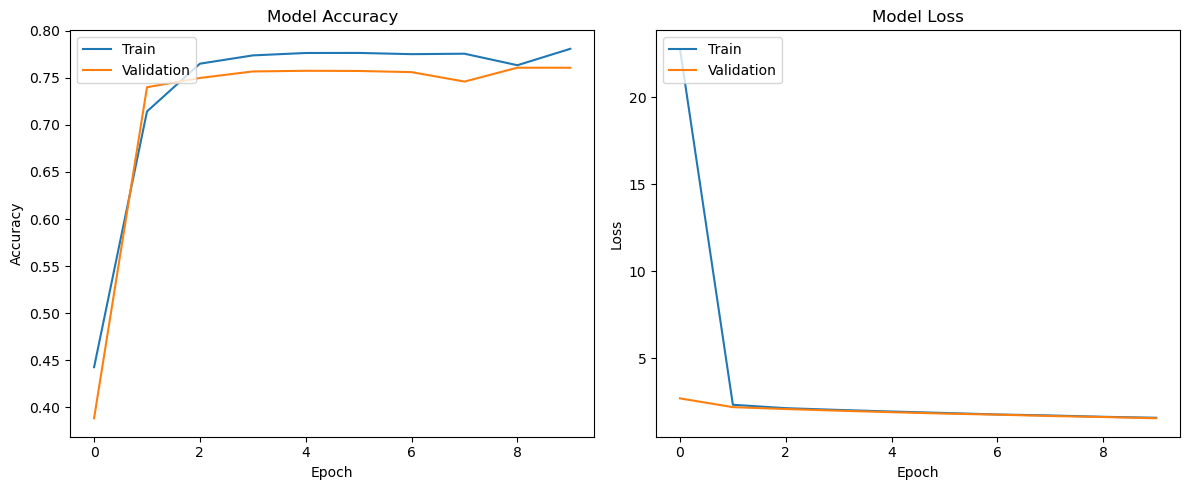

1/1 [==============================] - 0s 151ms/step


In [7]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

predictions = model.predict(test_tiles)


1/1 [==============================] - 0s 65ms/step
Accuracy: 0.7878
F1 Score: 0.6948
Recall: 0.7878


C:\Users\Hp OMEN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


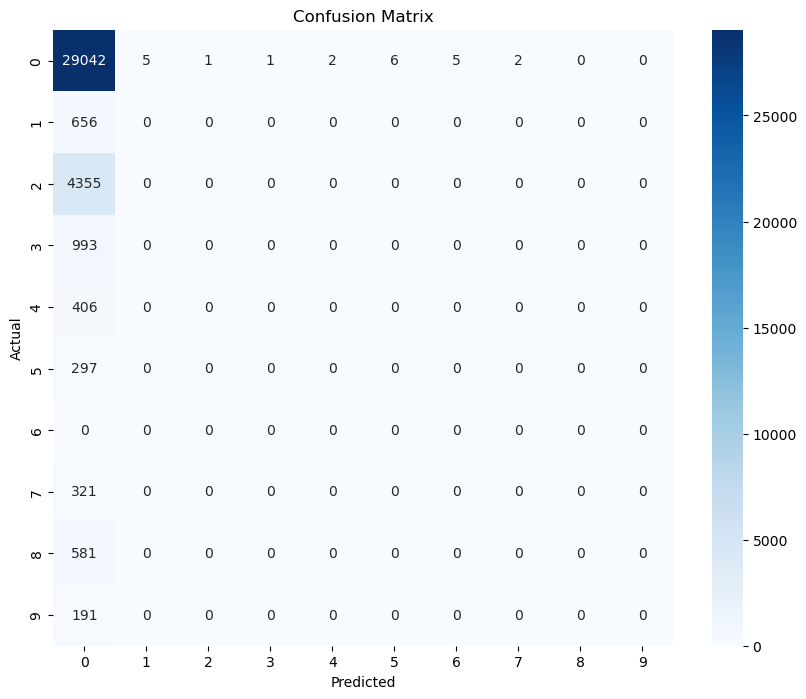

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score
import seaborn as sns
import pandas as pd

# Evaluate the model on test data to get predictions
predictions = model.predict(test_tiles)
predicted_labels = np.argmax(predictions, axis=-1)

# Calculate the confusion matrix
num_classes = 10  # Update this value based on your number of classes

# Calculate accuracy
accuracy = accuracy_score(testGT.flatten(), predicted_labels.flatten())
print(f'Accuracy: {accuracy:.4f}')

# Calculate F1 score
f1 = f1_score(testGT.flatten(), predicted_labels.flatten(), average='weighted')
print(f'F1 Score: {f1:.4f}')

# Calculate recall
recall = recall_score(testGT.flatten(), predicted_labels.flatten(), average='weighted')
print(f'Recall: {recall:.4f}')

conf_matrix = confusion_matrix(testGT.flatten(), predicted_labels.flatten(), labels=range(num_classes))

# Visualize the confusion matrix
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
